# Getting the optimal local Fourier approximation for MV-SDE

add description here

### Initialising libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import time

## McKean-Vlasov SDE of Kuramoto's type.

### We put here the function to simulate the Brownian motion.

In [2]:
def simulate_dW(N,T):
    return np.random.normal(size= N, scale = np.sqrt(T/N[1]))

def simulate_dW_1d(N,T):
    return np.random.normal(size = N, scale = np.sqrt(T/N))

### We initialise the main class.

We initialise the class of MV-SDE that admits the following dynamics:

$$
\text{d}X_t = \mathbb{E}[\sin(X_t-x)]_{\big|x = X_t}~\text{d}t + \sigma ~\text{d}W_t, \quad X_0 = x_0 \in L_2(\Omega).
$$

The drift can be equivalently rewritten as

$$
\mathbb{E}[\sin(X_t)] \cos(X_t) - \mathbb{E}[\cos(X_t)] \sin(X_t).
$$

In [48]:
class SDE_Kuramoto_MV ():
    
    #### Check the correct passing of the arguments
    
    def __init__(self, x_0 = 0, sigma = 1, dW_t = simulate_dW((100,100),1),
                 T = 1, n_discr = 100, n_part = 100):
        self.x_0 = np.random.normal(size = n_part, scale = 0.2)
        self.sigma = sigma
        self.T = T
        self.n_discr = n_discr
        self.n_part = n_part
        self.dt = self.T / self.n_discr
        self.dW_t = dW_t
        self.x = self.get_path()
        
    #### Simulates the path according to Euler algorithm    
    def get_path(self):
        x = np.zeros((self.n_part,self.n_discr))
        
        sum_sin = 0
        sum_cos = 0
        
        for j in range(self.n_part):
            x[j][0] = self.x_0[j]
            sum_sin += np.sin(x[j][0])
            sum_cos += np.cos(x[j][0])
        aver_sin = sum_sin / self.n_part
        aver_cos = sum_cos / self.n_part
        
        for i in range(1,self.n_discr):
            for j in range(self.n_part):
                
                x[j][i] = x[j][i - 1] + (np.cos(x[j][i - 1]) * aver_sin 
                                      - np.sin(x[j][i - 1]) * aver_cos) * self.dt + self.sigma * self.dW_t[j][i - 1]
                sum_sin += np.sin(x[j][i])
                sum_cos += np.cos(x[j][i])
            
            aver_sin = sum_sin / self.n_part
            aver_cos = sum_cos / self.n_part
            
            aver_sin
            
            sum_sin = 0
            sum_cos = 0
        return x
    
    #### Plots the path
    def plot_path(self):
        t = np.linspace(0, self.T, self.n_discr)
        
        fig, ax = plt.subplots(1,1,figsize=(15, 10), tight_layout=True)

        ax.set_title(r"Dynamics of the SDE", fontsize = 15)
        ax.set_xlabel(r'$t$',fontsize = 15)
        ax.set_ylabel(r'$X_t$',fontsize = 15)
        ax.tick_params(axis='both', which='major', labelsize = 20)
        ax.tick_params(axis='both', which='minor', labelsize = 20)
        for i in range(self.n_part):
            ax.plot(t, self.x[i][:])
        #ax.plot(t,[0]*t.shape[0],label = 'asymptote')
        plt.show()

        #ksi = self.get_path_for_gradient_SDE()

### Testing the class.

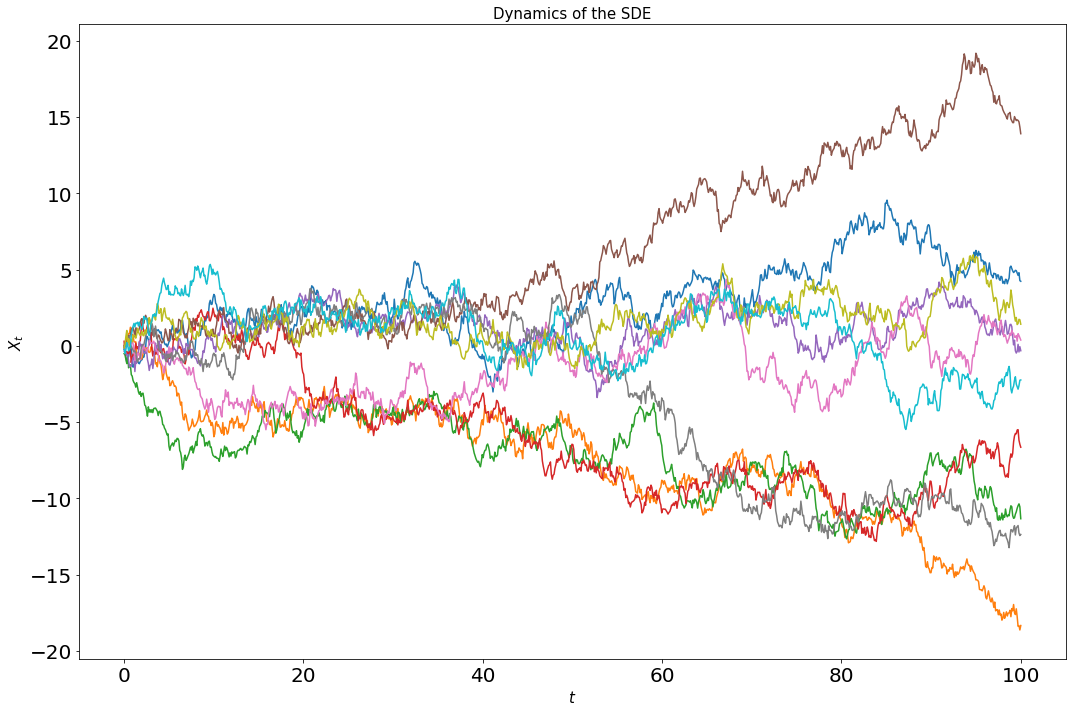

In [4]:
# Discretisation step to render the SDE and Gamma

# Initialise the number of Euler discretisation steps and time horizon
n_discr = 1000
T = 100
dt = T / n_discr

# Initialise the number of particles
n_part = 10

# Initialise the starting value and diffusion constant
x_0 = 1
sigma = 1

# Get the Wiener increments
dW_t = simulate_dW((n_part,n_discr),T)

# Initialise the class and render the dynamics
X = SDE_Kuramoto_MV(x_0, sigma, dW_t, T, n_discr, n_part)
X.plot_path()

## The approximation of MV-SDE's of Kuramoto type.

In [5]:
class SDE_Kuramoto_appr ():
    
    ### Check the correct passing of the arguments
    
    def __init__(self, x_0 = 0, sigma = 1, 
                 gamma = np.random.uniform(low = -1, high = 1, size = (2,100)), 
                 dW_t = simulate_dW_1d(100,1),  T = 1, n_discr = 100):
        self.x_0 = x_0
        self.sigma = sigma
        self.T = T
        self.n_discr = n_discr
        self.dt = self.T / self.n_discr
        self.gamma = gamma
        self.dW_t = dW_t
        self.x = self.get_path()
        self.ksi = self.get_path_for_gradient_SDE(k = 0, n = 0)
        
        
    #### Simulates the path according to Euler algorithm    
    def get_path(self):
        x = np.zeros(self.n_discr)
        x[0] = self.x_0 
        for i in range(1,self.n_discr):

            x[i] = x[i - 1] + (self.gamma[0][i - 1] * np.sin(x[i - 1]) - self.gamma[1][i - 1] * np.cos(x[i - 1])) * self.dt + self.sigma * self.dW_t[i - 1]
        return x

    #############
#############

#######DOUBLE CHECK FOR SIN VS COS

############
############

    def get_path_for_gradient_SDE(self,k,n):
        ksi = np.zeros(self.n_discr)
        for i in range(1,self.n_discr):
            ## check if i == n or n + 1
            if k == 0:
                if (i == n):
                    ksi[i] = ksi[i - 1] + (np.sin(self.x[i - 1]) + 
                                                 self.gamma[0][i - 1] * np.cos(self.x[i - 1]) * ksi[i - 1] + 
                                                 self.gamma[1][i - 1] * np.sin(self.x[i - 1]) * ksi[i - 1]) * self.dt + self.sigma * self.dW_t[i - 1] 
                elif (i != n):
                    ksi[i] = ksi[i - 1] + (self.gamma[0][i - 1] * np.cos(self.x[i - 1]) * ksi[i - 1] + 
                                                 self.gamma[1][i - 1] * np.sin(self.x[i - 1]) * ksi[i - 1]) * self.dt + self.sigma * self.dW_t[i - 1]
            ### CHECK the signs 
            
            elif k == 1:
                if (i == n):
                    ksi[i] = ksi[i - 1] + (-np.cos(self.x[i - 1]) + 
                                                     self.gamma[0][i - 1] * np.cos(self.x[i - 1]) * ksi[i - 1] + 
                                                     self.gamma[1][i - 1] * np.sin(self.x[i - 1]) * ksi[i - 1]) * self.dt + self.sigma * self.dW_t[i - 1]   
                elif (i != n):
                    ksi[i] = ksi[i - 1] + (self.gamma[0][i - 1] * np.cos(self.x[i - 1]) * ksi[i - 1] + 
                                                 self.gamma[1][i - 1] * np.sin(self.x[i - 1]) * ksi[i - 1]) * self.dt + self.sigma * self.dW_t[i - 1]
        return ksi
    
    #### Plots the path
    def plot_path(self):
        t = np.linspace(0, self.T, self.n_discr)
        
        fig, ax = plt.subplots(1,1,figsize=(15, 10), tight_layout=True)

        ax.set_title(r"Dynamics of the SDE", fontsize = 15)
        ax.set_xlabel(r'$t$',fontsize=15)
        ax.set_ylabel(r'$X_t$',fontsize=15)
        ax.tick_params(axis='both', which='major', labelsize = 20)
        ax.tick_params(axis='both', which='minor', labelsize = 20)
        ax.plot(t, self.x)
        ax.plot(t, self.ksi)
        #ax.plot(t, self.ksi[1])
        plt.show()
        
    def plot_grad_path(self):
        t = np.linspace(0, self.T, self.n_discr)
        
        fig, ax = plt.subplots(1,1,figsize=(15, 10), tight_layout=True)

        ax.set_title(r"Dynamics of the gradient SDE", fontsize = 15)
        ax.set_xlabel(r'$t$',fontsize=15)
        ax.set_ylabel(r'$\xi_t$',fontsize=15)
        ax.tick_params(axis='both', which='major', labelsize = 20)
        ax.tick_params(axis='both', which='minor', labelsize = 20)
        ax.plot(t, self.ksi[0])
        
        plt.show()
        
    def update_gamma(self, gamma):
        self.gamma = gamma
        x = self.get_path()
        #ksi = self.get_path_for_gradient_SDE()

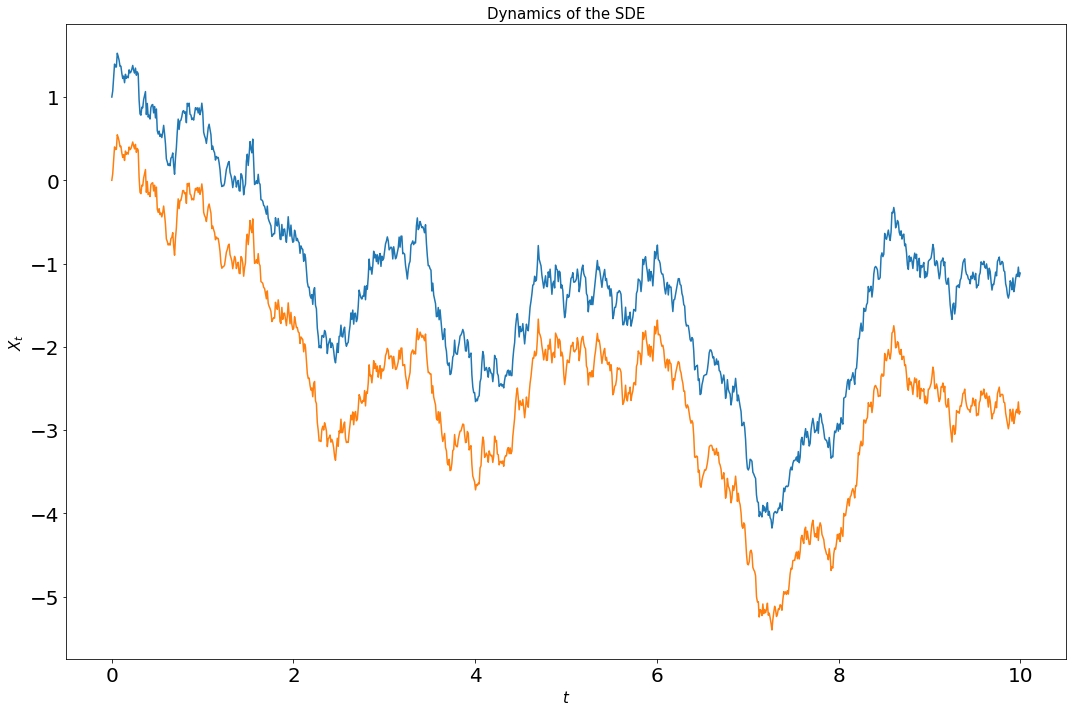

In [6]:
# Discretisation step to render the SDE and Gamma

# Initialisse the number of Euler discretisation steps and time horizon

n_discr = 1000
T = 10
dt = T / n_discr


# Initialise the starting value, drift function, starting guess for gamma and diffusion constant
x_0 = 1

gamma = np.random.uniform(low = - 1, high = 1, size = (2,n_discr))
sigma = 1

# Get the Wiener increments
dW_t = simulate_dW_1d(n_discr,T)

# Initialise the class and render the dynamics
X = SDE_Kuramoto_appr(x_0, sigma, gamma, dW_t, T, n_discr)
X.plot_path()
#X.plot_grad_path()

dW_t = simulate_dW((1,n_discr),T)

## Algorithm

We introduce the function that implements the algorithm.

In [36]:
eta = 0.01
N_iter = 100

# Initialise the number of Euler discretisation steps and time horizon

n_discr = 30
T = 1
dt = T / n_discr

# Initialise the starting value, starting guess for gamma and diffusion constant

x_0 = 1
gamma = np.random.uniform(low = - 0.7, high = 0.7, size = (2,n_discr))
#print(f'Starting gamma is {gamma}.')

def SGD_MV(n_discr, eta, gamma, T, eps, N_iter):
    
    gamma_aver = 0
    i = 0
    err = np.inf
    
    while (err > eps) and (i < N_iter):

        dW_t_1 = simulate_dW_1d(n_discr,T)
        dW_t_2 = simulate_dW_1d(n_discr,T)
        X_1 = SDE_Kuramoto_appr(x_0, sigma, gamma, dW_t_1, T, n_discr)
        X_2 = SDE_Kuramoto_appr(x_0, sigma, gamma, dW_t_2, T, n_discr)

        grad_first_part = np.zeros((2,n_discr))
        grad_first_part[0] = 2 * (np.sin(X_1.x) - gamma[0])
        grad_first_part[1] = 2 * (-np.cos(X_1.x) - gamma[1])
        grad_first_part = grad_first_part.reshape(2 * n_discr)

        jacobian = np.zeros((2 * n_discr, 2 * n_discr))

        for i_1 in range(n_discr):
            for k_1 in range(2):
                for i_2 in range(n_discr):
                    for k_2 in range(2):
                        if k_1 == 0:
                            jacobian[k_1 * n_discr + i_1][k_2 * n_discr + i_2] = np.cos(X_2.x[i_1]) * X_2.get_path_for_gradient_SDE(k_2,i_2)[i_1] - (i_1 == i_2 and k_1 == k_2)
                        elif k_1 == 1:
                            jacobian[k_1 * n_discr + i_1][k_2 * n_discr + i_2] = np.sin(X_2.x[i_1]) * X_2.get_path_for_gradient_SDE(k_2,i_2)[i_1] - (i_1 == i_2 and k_1 == k_2)

        ### Save Jacobian as a tensor?

        gamma = gamma.reshape(2 * n_discr)
        #print(gamma.shape)
        gamma = gamma - eta * np.matmul(grad_first_part,jacobian)
        gamma = gamma.reshape(2,n_discr)
        #print(gamma.shape)
        i += 1
    
    
    # ToDo: save the gamma for later to calculate the weighted average further on 
    
        gamma_aver = i / (i + 1) * gamma_aver + 1 / (i + 1) * gamma
        #print(f'Gamma average for {i} iteration is: \n {gamma_aver}')
        #print(f'Step {i} completed.')
    
    print(f'The solution of the SGD algorithm is {gamma_aver}.')
    return gamma_aver

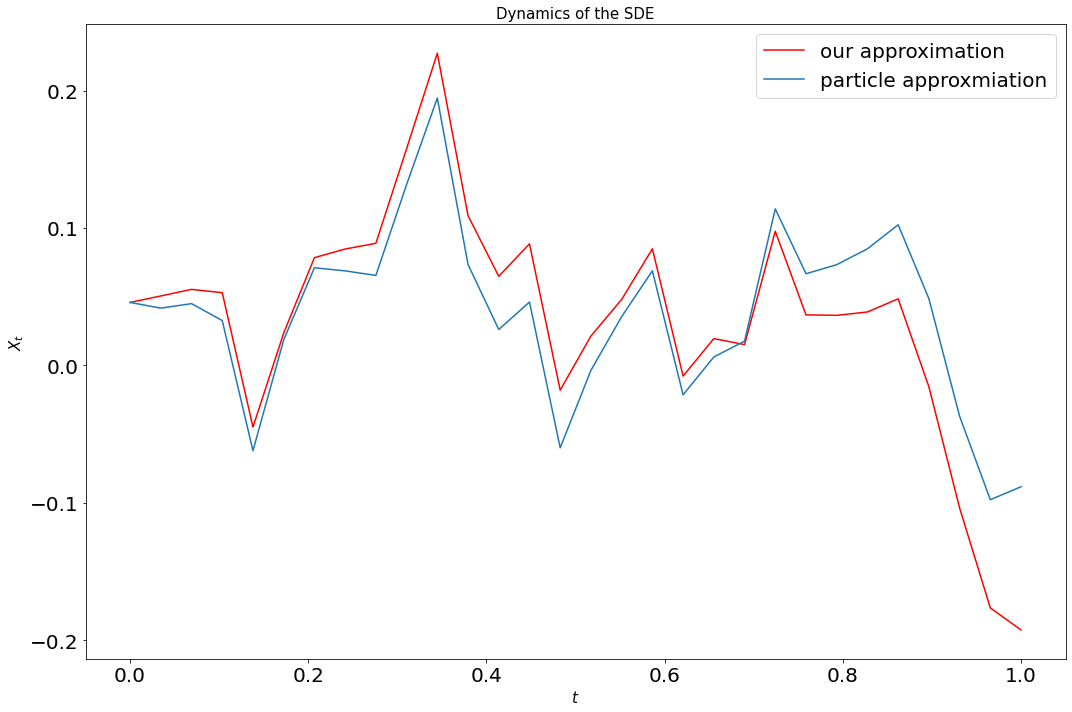

In [28]:
n_discr = 30
T = 1
dt = T / n_discr

# Initialise the starting value, starting guess for gamma and diffusion constant
x_0 = 1
sigma = 1


dW_t = simulate_dW((n_part,n_discr_2),T)
X_true = SDE_Kuramoto_MV(x_0, sigma, dW_t, T, n_discr, n_part)

# dW_t_truncated = dW_t[0]
X_test = SDE_Kuramoto_appr(X_true.x_0[0], sigma, gamma_aver, dW_t[0], T, n_discr)


t = np.linspace(0, T, n_discr)
        
fig, ax = plt.subplots(1,1,figsize=(15, 10), tight_layout=True)

ax.set_title(r"Dynamics of the SDE", fontsize = 15)
ax.set_xlabel(r'$t$',fontsize=15)
ax.set_ylabel(r'$X_t$',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize = 20)
ax.tick_params(axis='both', which='minor', labelsize = 20)

ax.plot(t, X_test.x, c = 'r', label = 'our approximation')
ax.plot(t, X_true.x[0], label = 'particle approxmiation')
plt.legend(loc='best', fontsize = 20)
plt.show()



In [37]:
n_discr = 100
n_mc = 10

x_0 = 1
sigma = 1

gamma_starting = np.random.uniform(low = - 0.3, high = 0.3, size = (2,n_discr))
gamma_ref_mc = gamma_starting
t_0 = time.time()
for i in range(n_mc):
    gamma_ref = SGD_MV(n_discr = 100, eta = 0.01, gamma = gamma_starting, T = 1, eps = 0, N_iter = 100)
    gamma_ref_mc = gamma_ref_mc * i / (i + 1) + gamma_ref * 1 / (i + 1)
    print(f'MC step {i} completed')
print(f'{n_mc} MC iterations time with {n_discr} grid size is: {time.time() - t_0:.{4}} s.')

The solution of the SGD algorithm is [[-0.45372692 -0.46297478 -0.49116391 -0.34317917 -0.43173244 -0.46167104
  -0.45682425 -0.49042378 -0.40505542 -0.35420124 -0.36394366 -0.34381451
  -0.57182837 -0.48428409 -0.52063866 -0.47156351 -0.38207142 -0.5111096
  -0.52169845 -0.42502783 -0.57800938 -0.56276747 -0.38764105 -0.38622289
  -0.5751761  -0.40949739 -0.49491864 -0.61762479 -0.60353831 -0.59576849
  -0.64902764 -0.40615593 -0.45866822 -0.61309746 -0.53194782 -0.51307023
  -0.54032965 -0.60031678 -0.51063582 -0.63031686 -0.67082955 -0.45970552
  -0.64634766 -0.6119934  -0.65399572 -0.51545172 -0.60793078 -0.72208254
  -0.68187718 -0.67670289 -0.56796395 -0.52122124 -0.72333178 -0.68785012
  -0.59303223 -0.51151544 -0.5381137  -0.57670236 -0.72801469 -0.64070494
  -0.7216042  -0.67707218 -0.69939691 -0.738807   -0.70021091 -0.78378787
  -0.5667587  -0.60028039 -0.56499953 -0.6916939  -0.79693063 -0.56372287
  -0.63131098 -0.81451983 -0.79656951 -0.7953564  -0.61156149 -0.73699855
  

KeyboardInterrupt: 

## Testing the variance of $\gamma$.

In [59]:
gamma_starting = np.random.uniform(low = - 0.3, high = 0.3, size = (2,10))
gammas = []

#eta = 0.05

for i in range(20):
    gamma_ref = SGD_MV(n_discr = 10, eta = 0.01, gamma = gamma_starting, T = 1, eps = 0, N_iter = 5000)
    #print(gamma_ref)
    gammas.append(gamma_ref)

The solution of the SGD algorithm is [[ 0.83796158  0.85037084  0.84419802  0.81925884  0.79151816  0.76441557
   0.72565285  0.6931726   0.65083457  0.61407989]
 [-0.52997137 -0.43086262 -0.33182342 -0.25219445 -0.17432115 -0.11455552
  -0.05523245 -0.01393209  0.02676917  0.06093378]].
The solution of the SGD algorithm is [[ 0.83620863  0.84571572  0.83380512  0.81029144  0.78551743  0.76245726
   0.72815095  0.69893049  0.65871662  0.6252727 ]
 [-0.53172432 -0.42760191 -0.34213437 -0.2580798  -0.18510287 -0.12818226
  -0.07319783 -0.025195    0.01434342  0.05704726]].
The solution of the SGD algorithm is [[ 0.83669853  0.84699664  0.83459633  0.81746476  0.79508527  0.76960215
   0.72917312  0.69902469  0.66596576  0.63226167]
 [-0.53123442 -0.42823267 -0.33795329 -0.25397018 -0.17890571 -0.12226899
  -0.06160058 -0.01699277  0.02023019  0.05462385]].
The solution of the SGD algorithm is [[ 0.83063082  0.83715363  0.8273902   0.80678227  0.78324881  0.76263339
   0.72686468  0.69003

KeyboardInterrupt: 

In [68]:
n_frequency_range = [2 ** i for i in range(7,0)] ## from 1 to 2^7

n_discr_range = [50,20,10,5,2]

x_0 = 1

n_mc = 1000000

##### ToDo: Run MC 50 times and get the average of empirical averages

##### Or: Check sup for a first step, then include the second, include the others by changing the frequency;
##### 


gamma_starting = np.random.uniform(low = - 0.3, high = 0.3, size = (2,n))

#gamma_ref = SGD_MV(n_discr = 100, eta = 0.01, gamma = gamma_starting, T = 1, eps = 0, N_iter = 1000)

'''gamma_ref should be for high discretisation, for example n_discr = 100'''
'''we choose the grid with lower number of nods and see how this improves, the gamma is fixed from the beginning'''


for n in n_discr_range:
    gamma_aver_mc = np.zeros((2,n))
    gamma_starting = np.random.uniform(low = - 0.3, high = 0.3, size = (2,n)) '''fix gamma for all of them!'''
    #gamma_ref_local = gamma_ref '''amend frequency here'''
    #gamma_starting = gamma_ref_local
    gamma_ref = SGD_MV(n_discr = n, eta = 0.01, gamma = gamma_starting, T = 1, eps = 0, N_iter = 1000)
    for i in range(n_mc):
        dW_t = simulate_dW_1d(n,T)
        X = SDE_Kuramoto_appr(x_0, sigma, gamma_ref, dW_t, T, n)
        gamma_aver_mc[0] = gamma_aver_mc[0] * i / (i + 1) + np.sin(X.x) * 1 / (i + 1)
        gamma_aver_mc[1] = gamma_aver_mc[1] * i / (i + 1) + (-np.cos(X.x)) * 1 / (i + 1)
    print(f'The difference between MC gamma_aver and gamma_aver from the algorithm for {n} is: \n\n{gamma_aver_mc - gamma_ref}')
    print(f'\nThe maximum norm for {n}: {abs(gamma_aver_mc - gamma_ref).max()}.')
    print('\n___________________________________________________________________________________________')
    print('___________________________________________________________________________________________\n')

The solution of the SGD algorithm is [[ 0.81435706  0.84391182  0.8271484   0.84835742  0.82424024  0.82244513
   0.80550743  0.80037756  0.80119456  0.76254849  0.75544594  0.73996043
   0.7229119   0.71732099  0.69863669  0.67937817  0.64371873  0.62489387
   0.60042338  0.60368762]
 [-0.50642042 -0.45082242 -0.4059763  -0.3492376  -0.30227184 -0.28672244
  -0.24582445 -0.19086582 -0.1729672  -0.12163552 -0.08746517 -0.06887442
  -0.0375873  -0.01163631  0.00749082  0.03020016  0.07645569  0.08776486
   0.10167529  0.1246787 ]].
The difference between MC gamma_aver and gamma_aver from the algorithm for 20 is: 

[[ 0.02711393  0.00100541  0.01788698 -0.00630198  0.01210167  0.00563879
   0.01303834  0.00668822 -0.00717988  0.01751159  0.00927116  0.00843944
   0.00890992 -0.00294505 -0.0021759  -0.00124964  0.01607051  0.01579585
   0.02096847 -0.00119856]
 [-0.03388189 -0.03629788 -0.03030612 -0.0394307  -0.04109367 -0.01510483
  -0.01603715 -0.03394936 -0.01734899 -0.03558476 -0.039